# **The Team: Magister**

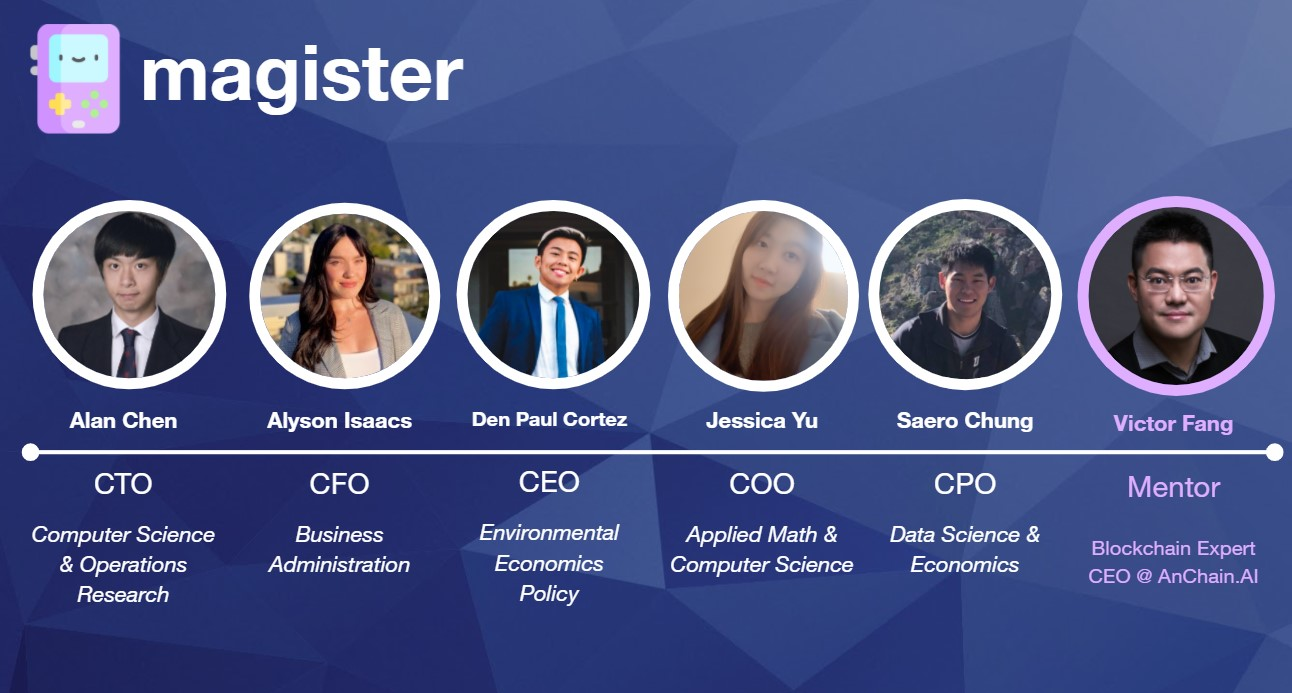

# **We created this Colab Notebook** to demonstrate two things
1. Value Proposition through disruptive technologies
2. Achievability and technical depth of our technical architecture, as shown on our diagram later.

# **Instructions on running the Code Samples**
1. Run every cell sequentially since there are dependencies such as imports.
2. There is an **Interactable UI in section Demonstration 2,** please run that after running the cells above!
3. There are descriptions of what the code does above each cell, and why we included it.
4. We will demonstrate **1. ML Infrastructure, 2. Intergration and Recommendation System, 3. Blockchain Integration**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.pyplot import figure
# machine learning models
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from web3 import Web3
# data science modules
import pandas as pd
import numpy as np
# UI building modules
import ipywidgets as widgets
from ipywidgets import Button, Box, HBox, VBox, GridBox, Layout, ButtonStyle, HTML, Image
from ipywidgets import interact, interactive, fixed
# widgets import
import markdown, json
import IPython
from IPython.display import display, clear_output, Markdown, update_display
# image import 
import requests
from io import BytesIO

# Data Import
For our Backend ML Demonstration, we will be an augmented real dataset on movie ratings by users. **We think recommendation system can be best demonstrated on a real dataset.** 

###  To demonstrate our value proposition, we will be predicting **User Engagement** as represented my **rating + some noise generated based on user's persona (See Demonstration 2)**.

In [2]:
movies = pd.read_csv('https://raw.githubusercontent.com/alanschen/magister/main/IMDB-Movie-Data.csv').drop(columns=['Rank', 'Description', 'Actors']).dropna()
movies['Genre'] = movies['Genre'].apply(lambda s: sorted(list(s.split(','))))
directors = {}
for d in movies['Director']:
    directors[d] = directors.get(d, len(directors))
genre_dict = {}
for lst in movies['Genre']:
    for g in lst:
        genre_dict[g] = genre_dict.get(g, len(genre_dict) + 1)
movies['Category1'] = movies['Genre'].apply(lambda x: genre_dict[x[0]])
movies['Category2'] = movies['Genre'].apply(lambda x: genre_dict[x[1]] if len(x) > 1 else 0)
movies['Category3'] = movies['Genre'].apply(lambda x: genre_dict[x[2]] if len(x) > 2 else 0)
movies['Number'] = movies['Genre'].apply(lambda x: len(x))
movies['Director'] = movies['Director'].apply(lambda x: directors[x])
movies['Year'] = movies['Year'] - 2006
movies['Rating'] = np.round(movies['Rating'], 1).astype(str)

def format_ml_data(movie_df):
    X, y = movie_df.drop(columns=['Title', 'Genre', 'Rating']), movie_df['Rating']
    return train_test_split(X, y, test_size=0.20, random_state=21)

def modify_by_interest(interests, dislikes=[]):
    def round(x):
        return np.round(max(0, min(x, 10)), 1)
    def overlaps(genre):
        return len(set(genre).intersection(set(interests))) - len(set(genre).intersection(set(dislikes)))
    modified = movies.copy(deep=True)
    modified['Rating'] = modified['Genre'].apply(overlaps) * np.random.normal(loc=1) + modified['Rating'].astype(float)
    modified['Rating'] = modified['Rating'].apply(round).astype(str)
    return modified

# Auxillary: Data Pipeline for Feature Transformation
This is a feature/data pipeline to make models and predictions more accurate. In production, we will be using a `NoSQL` database instead for faster delivery.

In [3]:
X_train, X_test, y_train, y_test = format_ml_data(movies)
selected_columns = list(X_train.columns)
def select_columns():
    ft = FunctionTransformer(lambda x: x[selected_columns])
    ft.get_feature_names = lambda: selected_columns
    return ft

def numerical_transforms():
    def transform_bins(name):
        return (name, KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile"), [name])
    def transform_norm(name):
        return (name, StandardScaler(), [name])
    return ColumnTransformer([
        ('Votes', KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile"), ['Votes']),
        ('Revenue (Millions)', StandardScaler(), ['Revenue (Millions)']),
        ('Metascore', KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile"), ['Metascore']),
        ('Runtime (Minutes)', KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile"), ['Runtime (Minutes)'])],
        remainder='passthrough')

def categorical_transforms():
    # Edit this ColumnTransformer to account for your chosen features
    return ColumnTransformer([
        ('Genre', OneHotEncoder(sparse=False), [list(selected_columns).index('Director')]),
        ('Director', OneHotEncoder(sparse=False), [list(selected_columns).index('Genre')]),
        ('Year', OneHotEncoder(sparse=False), [list(selected_columns).index('Year')])],
        remainder='passthrough')
    
full_pipeline = make_pipeline(select_columns(), numerical_transforms())
def display_pipeline(data):
    display(pd.DataFrame(full_pipeline.fit_transform(X_train), 
             columns=['Votes', 'Revenue (Millions)', 'Metascore', 'Runtime (Minutes)', 
                      'Director', 'Year', 'Category1', 'Category2', 'Category3', 'Number']).head())

# **Demonstration 1: Deep Learning & Backend Usering Tensorflow.Keras**
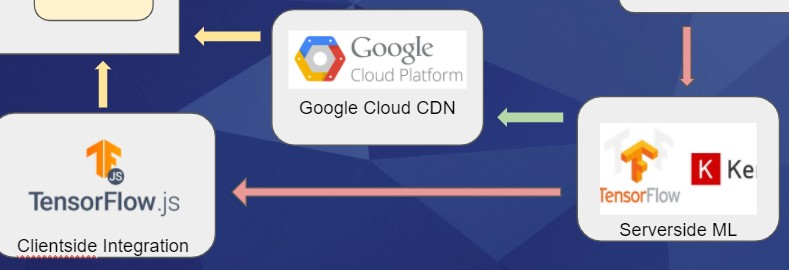
### We stated in our white paper we will be using `tensorflow.keras` for our ML content delivery. Here is 5 iteration of ML training, resulting in very good accuracy already.

#### **Note: Since we are not using Regression models, model `accuacy` is based on accuracy is engagement bins (i.e 8.0-8.1). Random guessing baseline accuracy is ~1% since we have 100 bins.**

In [4]:
def sparse_one_hot(x):
    return int(float(x))

dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.apply(sparse_one_hot)))
train_dataset = dataset.shuffle(len(X_train)).batch(1)

model = Sequential()
model.add(Dense(12, input_dim=10, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_dataset, epochs=5, verbose=2);

Epoch 1/5
670/670 - 0s - loss: 3077.3201 - accuracy: 0.3672
Epoch 2/5
670/670 - 0s - loss: 2.0049 - accuracy: 0.3731
Epoch 3/5
670/670 - 0s - loss: 1.7275 - accuracy: 0.3731
Epoch 4/5
670/670 - 0s - loss: 1.5772 - accuracy: 0.3731
Epoch 5/5
670/670 - 0s - loss: 1.4868 - accuracy: 0.3746


However, for our interactable demo later, we will be using a `scikit` **Random Forest** model because they are faster to fit and train for the purpose of UI in Python. **We want to show that our model can adapt to user interest, so we have to re-fit and re-train fast for demo**. 

Simple demonstration of model prediction accuracy: It is much lower than our `tf.keras` model earlier.

In [5]:
rdf = RandomForestClassifier(max_depth=4)
full_pipeline.fit(X_train)
X_train_tranformed = full_pipeline.transform(X_train)
X_test_tranformed = full_pipeline.transform(X_test)

full_pipeline.fit(X_test)
rdf.fit(X_train_tranformed, y_train)
print('random forest accuracy {} %'.format(np.round(rdf.score(X_test_tranformed, y_test) * 100 , 2)))

random forest accuracy 11.31 %


# Auxillary: User Persona Abstraction
Here is how we use object oriented programming to abstract user profile. A similar design can be used in real content delivery.

In [6]:
def fit_model_by_interest(likes, dislikes=[]):
    data = modify_by_interest(likes, dislikes)
    X_train, X_test, y_train, y_test = format_ml_data(data)

    full_pipeline = make_pipeline(select_columns(), numerical_transforms())
    full_pipeline.fit(X_train)
    X_train_tranformed = full_pipeline.transform(X_train)
    X_test_tranformed = full_pipeline.transform(X_test)

    full_pipeline.fit(X_test)
    rdf = RandomForestClassifier(max_depth=4).fit(X_train_tranformed, y_train)
    return data, X_test, y_test, rdf, full_pipeline

class Persona:
    def __init__(self, likes, dislikes=[]):
        self.likes = likes
        self.dislikes = dislikes
        # fitting a specialized model for this person
        self.data, X_test, y_test, self.model, self.pipeline = fit_model_by_interest(likes)
        y_pred = self.model.predict(X_test)
        X_test['User Rating'] = y_test.astype(float)
        X_test['Predicted User Rating'] = y_pred.astype(float)
        X_test = X_test.join(self.data[['Title', 'Genre']])
        X_test['Top Genre'] =X_test['Genre'].apply(lambda x: np.random.choice(x))
        self.suggestions = X_test.sort_values('Predicted User Rating', ascending=False)[['Title', 'Genre', 'Top Genre', 'User Rating', 'Predicted User Rating']]

        self.points = []
        self.watched = self.suggestions.copy()
        self.watched = self.watched[self.watched['User Rating'] > 11.]
        for title in self.suggestions.head(300).copy().sample(2)['Title']:
            self.watch(title)
    
    def suggest(self):
        suggested = self.suggestions.head(300).copy().sample(4)
        return suggested

    def watch(self, title):
        self.watched = self.watched.append(self.suggestions[self.suggestions['Title'] == title])
        self.suggestions = self.suggestions[self.suggestions['Title'] != title]
        if self.points == []:
            self.points += [5]
        else:
            self.points += [self.points[-1] + np.random.choice([1, 2, 5])]

    def exports(self):
        res = self.watched.copy()[['Title', 'Top Genre', 'User Rating']].rename(columns={'User Rating': 'Engagement'})
        res['Magister Points'] = self.points
        return res.tail()

# Auxillary: IPython UI Code
You can ignore the contenth here. It is all UI code for later.

In [7]:
b1 = "https://i.ibb.co/wBshwSc/justin-1.jpg"
colors = ['mintcream', 'lemonchiffon', 'tan', 'skyblue', 'ghostwhite', 'paleturquoise',
          'lightsteelblue', 'gainsboro', 'snow', 'orange', 'navajowhite', 'powderblue',
          'antiquewhite', 'tomato', 'lightyellow', 'thistle', 'lightseagreen', 'turquoise', 'silver', 'deepskyblue', 'wheat']
global_message = """### Description for your action will be displayed here"""

possible_genres = list(genre_dict.keys())
likes = [np.random.choice(possible_genres) for i in range(2)]
persona = Persona(likes)

def read_image(url, is_url=True):
    if is_url:
        return Image(value=BytesIO(requests.get(url).content).read())
    else:
        with open(url, 'rb') as f:
            file = f.read()
        return Image(value=file)

def get_image_box(url, fit='contain'):
    image_widget = read_image(url)
    image_widget.layout.object_fit = fit

    boxb = Box()
    boxb.children = [image_widget]
    return image_widget

def wrapper(general_widget):
    if type(general_widget) == str:
        return HTML(markdown.markdown(general_widget))
    boxb = Box()
    boxb.children = [general_widget]
    return boxb

def button(words, color='white', func=None):
    res = Button(description=words, layout=Layout(width='auto', height='auto'), style=ButtonStyle(button_color=color))
    if func != None:
        res.on_click(func)
    return res

def rerender():
    clear_output(wait=False)
    render()

def randomize_profile(b):
    global persona
    global global_message
    global likes
    likes = [np.random.choice(possible_genres) for i in range(2)]
    global_message = """### You just resetted the interest of this person! A new ML model has been fitted."""
    persona = Persona(likes)
    rerender()
    
def points_func(b):
    global global_message
    global_message = """### You just spent your {} magister points for fame!! """.format(persona.points[-1])
    persona.points[-1] = 0
    rerender()

def get_watch_box(i, suggestions):
    def watch_func(b):
        global global_message
        row = persona.suggestions[persona.suggestions['Title'] == title]
        actual, pred = row['User Rating'].iloc[0], row['Predicted User Rating'].iloc[0]
        global_message = """### You just watched {} , predicted engagement {}, actual {}""".format(genre, pred, actual)
        persona.watch(title)
        rerender()
    genre = suggestions.iloc[i]['Top Genre']
    title = suggestions.iloc[i]['Title']
    res = button("{}: {}".format(genre, title), color=colors[genre_dict[genre]], func=watch_func)
    return res

def render():
    exports = persona.exports()
    points, avg_engagement = persona.points[-1], np.round(np.average(exports['Engagement']), 2)
    last_watched_clr = colors[genre_dict[exports.iloc[-1]['Top Genre']]]
    last_watched_str = "Last Watched: {} (Title: {})".format(exports.iloc[-1]['Top Genre'], exports.iloc[-1]['Title'])
    suggestions = persona.suggest()

    fig=plt.figure()
    ax = fig.add_subplot(111)
    plt.style.use('ggplot')
    fig.set_size_inches(15, 10)
    plt.title('Video Watched Distribution', fontdict={'fontsize': 50})
    plt.hist(persona.watched['Top Genre'])
    plt.xticks(rotation=80, fontsize=50)
    fig.tight_layout()
    plt.savefig('foo.png');
    plt.close(fig)

    display(HBox([button("Randomize Profile", color='lightgreen', func=randomize_profile), wrapper(global_message)]))

    display(Markdown("## User Profile (Persona)"))
    display(GridBox(children=
                    [read_image(b1), wrapper("> # Justin \n > ## Age 16 \n > ## Interests: \n _*{}, {}*_".format(likes[0], likes[1])), read_image('foo.png', is_url=False)] + 
                    [button('{} Points'.format(points), color='BlanchedAlmond', func=points_func), 
                     button('Avgerage Engagement: {}'.format(avg_engagement), color='Lavender'), 
                     button(last_watched_str, color=last_watched_clr)],
            layout=Layout(
                width='50%',
                grid_template_columns='200px 200px 300px',
                grid_template_rows='200px 50px',
                grid_gap='0px 0px')
        ))
    display(Markdown("## Suggested Contents for Justin (click to simulate engagement)"))

    display(GridBox(children=[get_watch_box(i, suggestions) for i in range(4)],
            layout=Layout(
                width='75%',
                grid_template_columns='250px ' * 4,
                grid_template_rows='75px',
                grid_gap='0px 0px')
        ))
    display(Markdown("## Learning Passport & Smart Contract Rewards"))
    display(persona.exports())

# **Demonstration 2: AI Recommendation, Magister Points, and Profile Analytics**: 
This is not representative of our true UI, but it simulates how we want our back end and prediction system to look like. 
1. Run `render()` cell, make sure to keep the cell code in your screen for UI to not jitter.
2. Click`Randomize Profile` if you want to randomize student interest. **A new ML model will be fit to the new data-set.**
3. You can `spend magister coins` or `watch the suggested content` using this UI.
4. Learning history is documented & rewarded on  blockchain, shown as DataFrame

In [8]:
render()

## User Profile (Persona)

GridBox(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x0…

## Suggested Contents for Justin (click to simulate engagement)

GridBox(children=(Button(description='Comedy: Why Him?', layout=Layout(height='auto', width='auto'), style=But…

## Learning Passport & Smart Contract Rewards

,Title,Top Genre,Engagement,Magister Points
188,Drive,Drama,7.8,23
165,Twilight,Fantasy,5.2,28
773,Lady in the Water,Drama,6.3,33
683,The Mortal Instruments: City of Bones,Horror,5.9,35
143,Room,Drama,8.2,40


# **Demonstration 3: Secure and Self Executing Learning Rewards**
# There seems to be [new issues](https://stackoverflow.com/questions/64981354) with Web3's compabilility with Google Colab environment. So we can't use Web3.py to demonstrate live anymore 😞😞

---
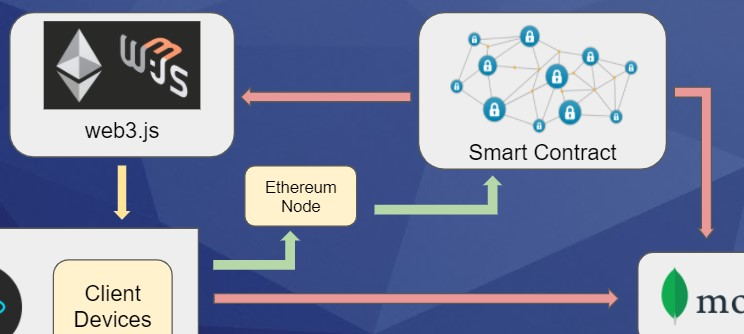

#### However, we did include screenshots of our **Rinkeby Test Blockchain** with links from Etherium Remix deployement as attached below. We also implemented a toy-version of our smart contract in Python to demonstrate our knowledge.
1. Deployed Smart Contract Sample: https://rinkeby.etherscan.io/address/0xcc085be8babe7c9b545b9a2f9221fbde7a3d4d60
2. Solidity Code Sample: https://www.dropbox.com/s/1kqt1xctozdmzk9/Learner.js?dl=0
3. Remix Testing Site: https://remix.ethereum.org/

In [9]:
read_image("https://i.ibb.co/DGJt2Y3/blockchain.jpg")

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\…

# Thank you for watching/using our demo!